In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as oc
import numpy as np
from mcpy.system import MCDriver

In [40]:
Ms = 3.84e5
A = 8.78e-12

d = 125e-9
hb = 20e-9
ht = 12.5e-9

cell = (5e-9, 5e-9, 2.5e-9)

D_bloch = {'r1': -1.58e-3, 'r2': 1.58e-3, "r1:r2": 1.58e-9}

In [41]:
def create_system():
    subregions = {'r1': df.Region(p1=(-d/2, -d/2, -hb), p2=(d/2, d/2, 0)), 'r2': df.Region(p1=(-d/2, -d/2, 0), p2=(d/2, d/2, ht))}

    p1 = (-d/2, -d/2, -hb)
    p2 = (d/2, d/2, ht)

    mesh = df.Mesh(p1=p1, p2=p2, cell=cell, subregions=subregions)

    def Ms_fun(point):
        x, y, z = point
        if x**2 + y**2 < (d/2)**2:
            return Ms
        else:
            return 0

    system = mm.System(name='bloch_point')

    system.energy = mm.Exchange(A=A) + mm.DMI(D=D_bloch, crystalclass='T')
    system.m = df.Field(mesh, dim=3, value=(0, 0, 1), norm=Ms_fun)

    return system

In [42]:
def topological_charge_bp(M):
    F_div = df.tools.emergent_magnetic_field(M.orientation).div
    F_int = df.integral(F_div * df.dV, direction='yz').integral(direction='x', improper=True)
    bp_charge = (F_int / (4 * np.pi)).array.squeeze()
    
    start = system.m.mesh.subregions['r1'].p1[0]
    end = system.m.mesh.subregions['r1'].p2[0]
    dx = system.m.mesh.cell[0]

    lengths = np.arange(start, end, dx)
    
    return bp_charge, lengths 

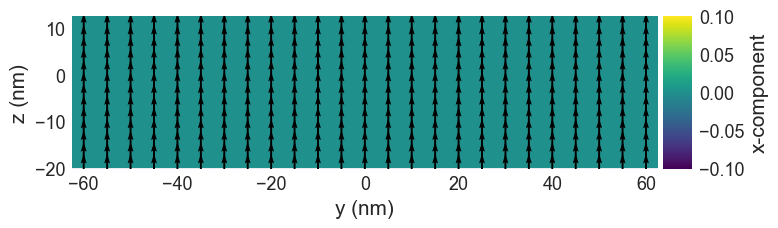

In [43]:
system = create_system()
system.m.plane('x').mpl()

Ubermag's Result

In [44]:
mc = oc.MinDriver()
mc.drive(system)

Running OOMMF (ExeOOMMFRunner)[2023/08/31 16:09]... (8.4 s)


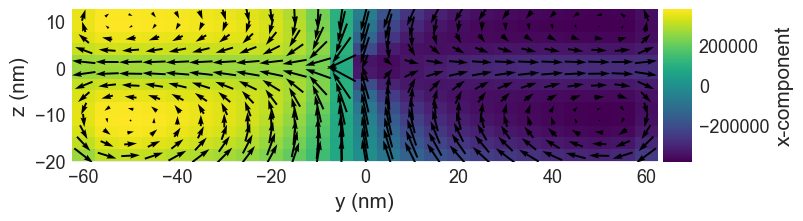

In [45]:
system.m.plane('x').mpl()

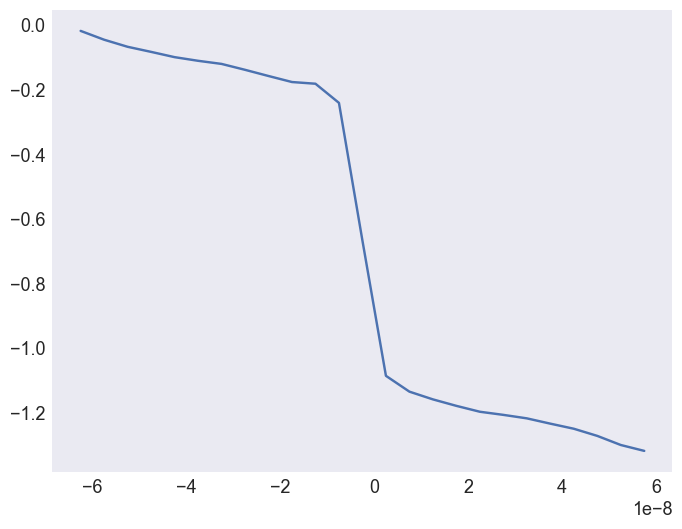

In [47]:
y, x = topological_charge_bp(system.m)

import matplotlib.pyplot as plt

plt.plot(x, y)
plt.show()

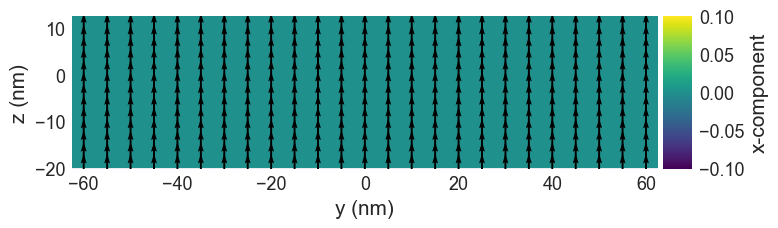

In [48]:
system = create_system()
system.m.plane('x').mpl()

McPy results 

In [10]:
mc = MCDriver(system, schedule_name='bloch_point_finer', schedule={'type': 'FC', 'start_temp': 60, 'end_temp': 1, 'steps': 3})

exchange.A found.
dmi.crystalclass found.
Schedule initialized: FC
Start temperature: 60K
Steps: 3
End temperature will be 1.0K in -19.667K per steps.
Start field: 0.0 A/m
End field will be: 0.0 in 0.0 A/m per steps.


In [49]:
mc = MCDriver(system)

exchange.A found.
dmi.crystalclass found.


In [52]:
mc.temperature = 50

In [53]:
mc.drive(N=50000000)

Step: 0, Temperature: 50K, Field: 0.0 A/m
Bloch point: {'bp_number': 0.0, 'bp_number_hh': 0.0, 'bp_number_tt': 0.0, 'bp_pattern_x': '[[-0.0, 25]]'}
Average Magnetisation: [-1.59109837e-03  8.18117402e-04  8.91160165e-01]


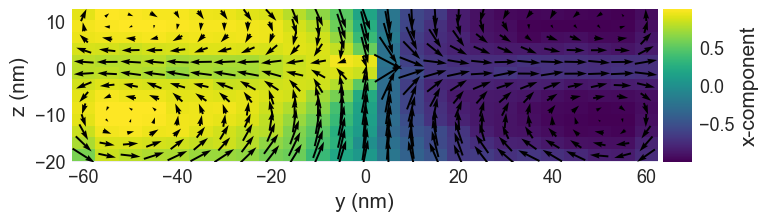

In [55]:
mc.grid.plot('x')

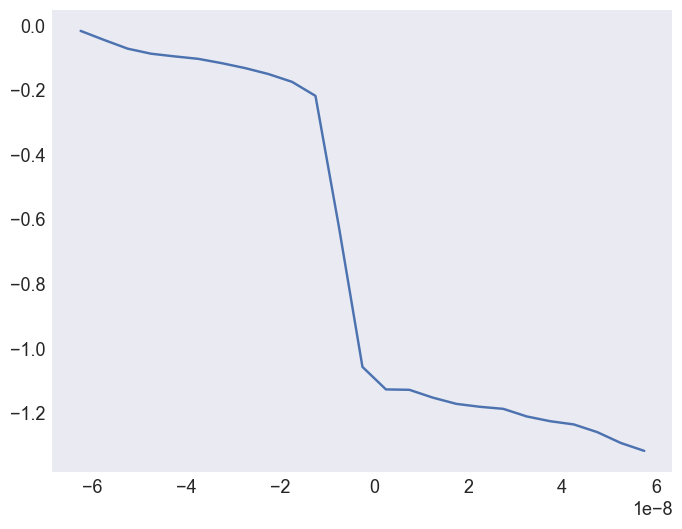

In [56]:
y_mc, x_mc = topological_charge_bp(system.m)

plt.plot(x_mc, y_mc)
plt.show()

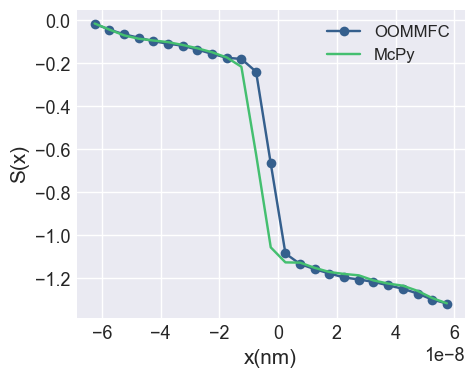

In [77]:
oomfc_data = zip(x_mc, y_mc)

In [78]:
new_data = np.array(tuple(oomfc_data))

In [79]:
with open("images/mc_data.npy", "wb") as f:
    np.save(f, new_data)

In [75]:
loaded_data = np.load("images/oommfc_data.npy", allow_pickle=True)